# Exercici 1: Classificació d'imatges amb Fashion MNIST

Donat el dataset FashionMNIST, definir una arquitectura, càrrega de dades i entrenament d'un algoritme de classificació amb deep learning per tal de classificar el dataset. 

Donar l'accuracy de l'algoritme sobre el conjunt de test i la matriu de confusió. Mostrar també l'evolució del loss d'entrenament i validació al llarg de les iteracions


In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, classification_report

In [10]:
fashion_data = datasets.FashionMNIST('./fashion_data', download=True)

In [11]:
# Data loaders

batch_size_train = 64
batch_size_test = 1000

data_transformation = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.1307,), (0.3081,))
])
                                          
train_loader = torch.utils.data.DataLoader(datasets.FashionMNIST('./fashion_data', 
                                                                             train=True, 
                                                                             download=False,
                                                                             transform=data_transformation), 
                                          batch_size=batch_size_train,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(datasets.FashionMNIST('./fashion_data', 
                                                                            train=False, 
                                                                            download=False,
                                                                            transform=data_transformation),
                                          batch_size = batch_size_test,
                                          shuffle=True)

In [12]:
# Architecture

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 20, 5, 1), # 24x24@20
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 12x12@20
            nn.Dropout2d(0.4)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(20, 50, 5, 1), # 8x8@50
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 4x4@50
            nn.Dropout2d(0.4)
        ) 
        
        self.fc1 = nn.Sequential(
            nn.Linear(4*4*50, 512),
            nn.ReLU()        
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU()        
        )
        
        self.out = nn.Sequential(
            nn.Linear(128, 10)
        )
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        # https://discuss.pytorch.org/t/runtimeerror-size-mismatch-m1-3136-x-1-m2-784-x-100/26877/2
        x = x.view(x.size(0), -1,)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.out(x)
        
        return x

In [13]:
# Hyperparameters
learning_rate = 0.01
momentum = 0.8
seed = 42

epochs = 10
log_interval=10

device = torch.device("cuda" if torch.cuda.is_available else "cpu")

model = Net().to(device)

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()

In [14]:
# Training

def train(model, train_loader, optimizer, device):
    model.train()
    train_losses = []
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, 
                batch_idx * len(data), 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.item()))
            
            train_losses.append(loss.item())
    
    return train_losses
        

In [15]:
# Test

def test(model, test_loader, device):
    model.eval()
    test_loss = 0
    correct = 0
    test_losses = []
    predictions = []
    accuracies = []
    labels = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            labels.append(target)
            output = model(data)
            test_loss += criterion(output, target)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            predictions.append(pred)
            
            test_loss /= len(test_loader.dataset)
            test_losses.append(test_loss)
            
            acc = 100. * correct / len(test_loader.dataset)
            accuracies.append(acc)
    
            print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
                test_loss, 
                correct, 
                len(test_loader.dataset),
                acc))
    
    return test_losses, predictions, accuracies, labels

In [16]:
# Run training and test
train_losses = []
test_losses = []
test_accuracies = []
test_predictions = []
test_labels = []

for epoch in range(1, epochs + 1):
    train_losses.extend(train(model, train_loader, optimizer, device))
    
    t_losses, t_pred, t_accs, t_labels = test(model, test_loader, device)
    test_losses.extend(t_losses)
    test_predictions.extend(t_pred)
    test_accuracies.extend(t_accs)
    test_labels.extend(t_labels)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301738
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.301437
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.293979
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.276993
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.248216
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.222391
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.090180
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.797637
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.391041
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.166212
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.103658
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.316315
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.114840
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.098207
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.914408
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.692998
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.156351
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.174398
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.997294
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.877313
Train Epoch: 1 [12800/60000 (

Train Epoch: 2 [39040/60000 (65%)]	Loss: 0.601654
Train Epoch: 2 [39680/60000 (66%)]	Loss: 0.502924
Train Epoch: 2 [40320/60000 (67%)]	Loss: 0.482138
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.428171
Train Epoch: 2 [41600/60000 (69%)]	Loss: 0.375107
Train Epoch: 2 [42240/60000 (70%)]	Loss: 0.560727
Train Epoch: 2 [42880/60000 (71%)]	Loss: 0.552593
Train Epoch: 2 [43520/60000 (72%)]	Loss: 0.418104
Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.505147
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.315572
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.583290
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.650642
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.431995
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.469483
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.479243
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.590132
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.380979
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.395753
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.487190
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.340431


Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.414307
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.519385
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.318545
Train Epoch: 4 [12160/60000 (20%)]	Loss: 0.560751
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.331535
Train Epoch: 4 [13440/60000 (22%)]	Loss: 0.321417
Train Epoch: 4 [14080/60000 (23%)]	Loss: 0.587231
Train Epoch: 4 [14720/60000 (25%)]	Loss: 0.441929
Train Epoch: 4 [15360/60000 (26%)]	Loss: 0.417452
Train Epoch: 4 [16000/60000 (27%)]	Loss: 0.599597
Train Epoch: 4 [16640/60000 (28%)]	Loss: 0.577145
Train Epoch: 4 [17280/60000 (29%)]	Loss: 0.311608
Train Epoch: 4 [17920/60000 (30%)]	Loss: 0.353370
Train Epoch: 4 [18560/60000 (31%)]	Loss: 0.535680
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.553448
Train Epoch: 4 [19840/60000 (33%)]	Loss: 0.427222
Train Epoch: 4 [20480/60000 (34%)]	Loss: 0.354048
Train Epoch: 4 [21120/60000 (35%)]	Loss: 0.189635
Train Epoch: 4 [21760/60000 (36%)]	Loss: 0.321443
Train Epoch: 4 [22400/60000 (37%)]	Loss: 0.448478


Train Epoch: 5 [48000/60000 (80%)]	Loss: 0.409388
Train Epoch: 5 [48640/60000 (81%)]	Loss: 0.356072
Train Epoch: 5 [49280/60000 (82%)]	Loss: 0.392909
Train Epoch: 5 [49920/60000 (83%)]	Loss: 0.238232
Train Epoch: 5 [50560/60000 (84%)]	Loss: 0.377426
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.311262
Train Epoch: 5 [51840/60000 (86%)]	Loss: 0.542054
Train Epoch: 5 [52480/60000 (87%)]	Loss: 0.338417
Train Epoch: 5 [53120/60000 (88%)]	Loss: 0.337254
Train Epoch: 5 [53760/60000 (90%)]	Loss: 0.449574
Train Epoch: 5 [54400/60000 (91%)]	Loss: 0.349952
Train Epoch: 5 [55040/60000 (92%)]	Loss: 0.373770
Train Epoch: 5 [55680/60000 (93%)]	Loss: 0.295290
Train Epoch: 5 [56320/60000 (94%)]	Loss: 0.369960
Train Epoch: 5 [56960/60000 (95%)]	Loss: 0.312727
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.334816
Train Epoch: 5 [58240/60000 (97%)]	Loss: 0.366828
Train Epoch: 5 [58880/60000 (98%)]	Loss: 0.295642
Train Epoch: 5 [59520/60000 (99%)]	Loss: 0.346960

Test set: Average loss: 0.0000, Accuracy: 866/100

Train Epoch: 7 [18560/60000 (31%)]	Loss: 0.156696
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.391685
Train Epoch: 7 [19840/60000 (33%)]	Loss: 0.279858
Train Epoch: 7 [20480/60000 (34%)]	Loss: 0.177563
Train Epoch: 7 [21120/60000 (35%)]	Loss: 0.193336
Train Epoch: 7 [21760/60000 (36%)]	Loss: 0.520677
Train Epoch: 7 [22400/60000 (37%)]	Loss: 0.231654
Train Epoch: 7 [23040/60000 (38%)]	Loss: 0.258642
Train Epoch: 7 [23680/60000 (39%)]	Loss: 0.223150
Train Epoch: 7 [24320/60000 (41%)]	Loss: 0.301369
Train Epoch: 7 [24960/60000 (42%)]	Loss: 0.396746
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.394695
Train Epoch: 7 [26240/60000 (44%)]	Loss: 0.347495
Train Epoch: 7 [26880/60000 (45%)]	Loss: 0.463487
Train Epoch: 7 [27520/60000 (46%)]	Loss: 0.295557
Train Epoch: 7 [28160/60000 (47%)]	Loss: 0.252856
Train Epoch: 7 [28800/60000 (48%)]	Loss: 0.297648
Train Epoch: 7 [29440/60000 (49%)]	Loss: 0.428750
Train Epoch: 7 [30080/60000 (50%)]	Loss: 0.560474
Train Epoch: 7 [30720/60000 (51%)]	Loss: 0.361892


Train Epoch: 8 [56320/60000 (94%)]	Loss: 0.297924
Train Epoch: 8 [56960/60000 (95%)]	Loss: 0.353866
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.422979
Train Epoch: 8 [58240/60000 (97%)]	Loss: 0.507937
Train Epoch: 8 [58880/60000 (98%)]	Loss: 0.239700
Train Epoch: 8 [59520/60000 (99%)]	Loss: 0.354942

Test set: Average loss: 0.0000, Accuracy: 872/10000 (9%)

Test set: Average loss: 0.0000, Accuracy: 1766/10000 (18%)

Test set: Average loss: 0.0000, Accuracy: 2656/10000 (27%)

Test set: Average loss: 0.0000, Accuracy: 3546/10000 (35%)

Test set: Average loss: 0.0000, Accuracy: 4415/10000 (44%)

Test set: Average loss: 0.0000, Accuracy: 5301/10000 (53%)

Test set: Average loss: 0.0000, Accuracy: 6198/10000 (62%)

Test set: Average loss: 0.0000, Accuracy: 7096/10000 (71%)

Test set: Average loss: 0.0000, Accuracy: 7999/10000 (80%)

Test set: Average loss: 0.0000, Accuracy: 8904/10000 (89%)
Train Epoch: 9 [0/60000 (0%)]	Loss: 0.248709
Train Epoch: 9 [640/60000 (1%)]	Loss: 0.367365
Train Epoc

Train Epoch: 10 [26880/60000 (45%)]	Loss: 0.400522
Train Epoch: 10 [27520/60000 (46%)]	Loss: 0.389362
Train Epoch: 10 [28160/60000 (47%)]	Loss: 0.239979
Train Epoch: 10 [28800/60000 (48%)]	Loss: 0.211082
Train Epoch: 10 [29440/60000 (49%)]	Loss: 0.339700
Train Epoch: 10 [30080/60000 (50%)]	Loss: 0.322612
Train Epoch: 10 [30720/60000 (51%)]	Loss: 0.319194
Train Epoch: 10 [31360/60000 (52%)]	Loss: 0.197443
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.196832
Train Epoch: 10 [32640/60000 (54%)]	Loss: 0.320036
Train Epoch: 10 [33280/60000 (55%)]	Loss: 0.292694
Train Epoch: 10 [33920/60000 (57%)]	Loss: 0.196727
Train Epoch: 10 [34560/60000 (58%)]	Loss: 0.177285
Train Epoch: 10 [35200/60000 (59%)]	Loss: 0.227528
Train Epoch: 10 [35840/60000 (60%)]	Loss: 0.348716
Train Epoch: 10 [36480/60000 (61%)]	Loss: 0.366205
Train Epoch: 10 [37120/60000 (62%)]	Loss: 0.257495
Train Epoch: 10 [37760/60000 (63%)]	Loss: 0.248412
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.509695
Train Epoch: 10 [39040/60000 (6

In [ ]:
# Show results

#test(model, test_loader, device)

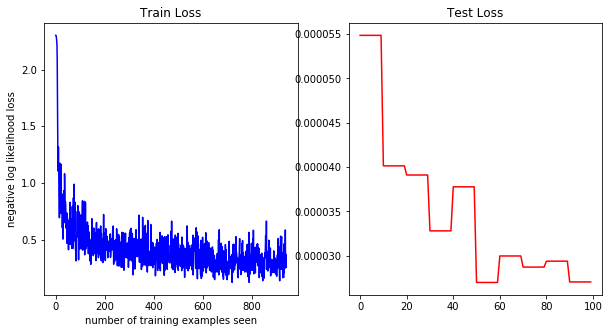

In [17]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_losses, color='blue')
plt.title('Train Loss')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

plt.subplot(1,2,2)
plt.title('Test Loss')
plt.plot(test_losses, color='red')

#fig

In [18]:
from itertools import chain

predictions_l = [test_predictions[i].tolist() for i in range(len(test_predictions))]
labels_l = [test_labels[i].tolist() for i in range(len(test_labels))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))

# Fix to make it run in lab
predictions_l = np.ravel(predictions_l)
labels_l = np.ravel(labels_l)

In [19]:
confusion_matrix(labels_l, predictions_l)

print("Classification report for CNN :\n%s\n"
      % (classification_report(labels_l, predictions_l)))

Classification report for CNN :
              precision    recall  f1-score   support

           0       0.83      0.80      0.82     10000
           1       0.98      0.97      0.98     10000
           2       0.82      0.73      0.77     10000
           3       0.88      0.89      0.88     10000
           4       0.76      0.81      0.78     10000
           5       0.97      0.96      0.96     10000
           6       0.62      0.66      0.64     10000
           7       0.93      0.95      0.94     10000
           8       0.97      0.96      0.97     10000
           9       0.95      0.95      0.95     10000

    accuracy                           0.87    100000
   macro avg       0.87      0.87      0.87    100000
weighted avg       0.87      0.87      0.87    100000




# Exercici 2: Transformacions de dades

Aplicar diferents transformacions de dades a FashionMNIST per tal de millorar la generalització de l'arquitectura del problema anterior.

Donar l'accuracy de l'algoritme sobre el conjunt de test i la matriu de confusió. Mostrar també l'evolució del loss d'entrenament i validació al llarg de les iteracions





In [21]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, classification_report

In [22]:
fashion_data = datasets.FashionMNIST('./fashion_data', download=True)

In [23]:
# Data loaders

batch_size_train = 64
batch_size_test = 1000

# Apply Rotation and HorizontalFlip tranformations

data_transformation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(), 
    transforms.Normalize((0.1307,), (0.3081,))
])
                                          
train_loader = torch.utils.data.DataLoader(datasets.FashionMNIST('./fashion_data', 
                                                                             train=True, 
                                                                             download=False,
                                                                             transform=data_transformation), 
                                          batch_size=batch_size_train,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(datasets.FashionMNIST('./fashion_data', 
                                                                            train=False, 
                                                                            download=False,
                                                                            transform=data_transformation),
                                          batch_size = batch_size_test,
                                          shuffle=True)

In [24]:
# Architecture

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 20, 5, 1), # 24x24@20
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 12x12@20
            nn.Dropout2d(0.4)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(20, 50, 5, 1), # 8x8@50
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 4x4@50
            nn.Dropout2d(0.4)
        ) 
        
        self.fc1 = nn.Sequential(
            nn.Linear(4*4*50, 512),
            nn.ReLU()        
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU()        
        )
        
        self.out = nn.Sequential(
            nn.Linear(128, 10)
        )
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        # https://discuss.pytorch.org/t/runtimeerror-size-mismatch-m1-3136-x-1-m2-784-x-100/26877/2
        x = x.view(x.size(0), -1,)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.out(x)
        
        return x

In [25]:
# Hyperparameters
learning_rate = 0.01
momentum = 0.8
seed = 42

epochs = 10
log_interval=10

device = torch.device("cuda" if torch.cuda.is_available else "cpu")

model = Net().to(device)

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()

In [26]:
# Training

def train(model, train_loader, optimizer, device):
    model.train()
    train_losses = []
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, 
                batch_idx * len(data), 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.item()))
            
            train_losses.append(loss.item())
    
    return train_losses

In [27]:
# Test

def test(model, test_loader, device):
    model.eval()
    test_loss = 0
    correct = 0
    test_losses = []
    predictions = []
    accuracies = []
    labels = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            labels.append(target)
            output = model(data)
            test_loss += criterion(output, target)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            predictions.append(pred)
            
            test_loss /= len(test_loader.dataset)
            test_losses.append(test_loss)
            
            acc = 100. * correct / len(test_loader.dataset)
            accuracies.append(acc)
    
            print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
                test_loss, 
                correct, 
                len(test_loader.dataset),
                acc))
    
    return test_losses, predictions, accuracies, labels

In [28]:
# Run training and test
train_losses = []
test_losses = []
test_accuracies = []
test_predictions = []
test_labels = []

for epoch in range(1, epochs + 1):
    train_losses.extend(train(model, train_loader, optimizer, device))
    
    t_losses, t_pred, t_accs, t_labels = test(model, test_loader, device)
    test_losses.extend(t_losses)
    test_predictions.extend(t_pred)
    test_accuracies.extend(t_accs)
    test_labels.extend(t_labels)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.311501
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.299473
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.286693
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.266105
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.255776
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.288182
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.172958
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.062897
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.841862
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.625663
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.548035
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.492133
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.514131
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.300700
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.315621
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.320625
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.514877
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.370874
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.103334
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.978019
Train Epoch: 1 [12800/60000 (

Train Epoch: 2 [39040/60000 (65%)]	Loss: 0.779244
Train Epoch: 2 [39680/60000 (66%)]	Loss: 0.529442
Train Epoch: 2 [40320/60000 (67%)]	Loss: 1.059026
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.610920
Train Epoch: 2 [41600/60000 (69%)]	Loss: 0.548231
Train Epoch: 2 [42240/60000 (70%)]	Loss: 0.751723
Train Epoch: 2 [42880/60000 (71%)]	Loss: 0.679298
Train Epoch: 2 [43520/60000 (72%)]	Loss: 0.990258
Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.481198
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.745529
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.703211
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.841853
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.645687
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.788228
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.505381
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.553508
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.862366
Train Epoch: 2 [49920/60000 (83%)]	Loss: 1.011212
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.637697
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.678501


Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.787127
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.452987
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.639737
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.612985
Train Epoch: 4 [12160/60000 (20%)]	Loss: 0.585937
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.593085
Train Epoch: 4 [13440/60000 (22%)]	Loss: 0.496564
Train Epoch: 4 [14080/60000 (23%)]	Loss: 0.524222
Train Epoch: 4 [14720/60000 (25%)]	Loss: 0.476457
Train Epoch: 4 [15360/60000 (26%)]	Loss: 0.631258
Train Epoch: 4 [16000/60000 (27%)]	Loss: 0.592417
Train Epoch: 4 [16640/60000 (28%)]	Loss: 0.701978
Train Epoch: 4 [17280/60000 (29%)]	Loss: 0.535520
Train Epoch: 4 [17920/60000 (30%)]	Loss: 0.554697
Train Epoch: 4 [18560/60000 (31%)]	Loss: 0.664623
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.483844
Train Epoch: 4 [19840/60000 (33%)]	Loss: 0.530625
Train Epoch: 4 [20480/60000 (34%)]	Loss: 0.745107
Train Epoch: 4 [21120/60000 (35%)]	Loss: 0.570361
Train Epoch: 4 [21760/60000 (36%)]	Loss: 0.582372
T

Train Epoch: 5 [48000/60000 (80%)]	Loss: 0.580177
Train Epoch: 5 [48640/60000 (81%)]	Loss: 0.628859
Train Epoch: 5 [49280/60000 (82%)]	Loss: 0.453012
Train Epoch: 5 [49920/60000 (83%)]	Loss: 0.417718
Train Epoch: 5 [50560/60000 (84%)]	Loss: 0.691003
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.584708
Train Epoch: 5 [51840/60000 (86%)]	Loss: 0.598642
Train Epoch: 5 [52480/60000 (87%)]	Loss: 0.582806
Train Epoch: 5 [53120/60000 (88%)]	Loss: 0.597626
Train Epoch: 5 [53760/60000 (90%)]	Loss: 0.801640
Train Epoch: 5 [54400/60000 (91%)]	Loss: 0.529918
Train Epoch: 5 [55040/60000 (92%)]	Loss: 0.302542
Train Epoch: 5 [55680/60000 (93%)]	Loss: 0.576705
Train Epoch: 5 [56320/60000 (94%)]	Loss: 0.431191
Train Epoch: 5 [56960/60000 (95%)]	Loss: 0.555224
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.583165
Train Epoch: 5 [58240/60000 (97%)]	Loss: 0.748747
Train Epoch: 5 [58880/60000 (98%)]	Loss: 0.484000
Train Epoch: 5 [59520/60000 (99%)]	Loss: 0.480417
Test set: Average loss: 0.0000, Accuracy: 809/1000

Train Epoch: 7 [18560/60000 (31%)]	Loss: 0.623606
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.476054
Train Epoch: 7 [19840/60000 (33%)]	Loss: 0.684981
Train Epoch: 7 [20480/60000 (34%)]	Loss: 0.439102
Train Epoch: 7 [21120/60000 (35%)]	Loss: 0.626361
Train Epoch: 7 [21760/60000 (36%)]	Loss: 0.522858
Train Epoch: 7 [22400/60000 (37%)]	Loss: 0.473325
Train Epoch: 7 [23040/60000 (38%)]	Loss: 0.571998
Train Epoch: 7 [23680/60000 (39%)]	Loss: 0.614548
Train Epoch: 7 [24320/60000 (41%)]	Loss: 0.579613
Train Epoch: 7 [24960/60000 (42%)]	Loss: 0.464436
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.522434
Train Epoch: 7 [26240/60000 (44%)]	Loss: 0.504441
Train Epoch: 7 [26880/60000 (45%)]	Loss: 0.452745
Train Epoch: 7 [27520/60000 (46%)]	Loss: 0.505774
Train Epoch: 7 [28160/60000 (47%)]	Loss: 0.454546
Train Epoch: 7 [28800/60000 (48%)]	Loss: 0.425037
Train Epoch: 7 [29440/60000 (49%)]	Loss: 0.487305
Train Epoch: 7 [30080/60000 (50%)]	Loss: 0.413193
Train Epoch: 7 [30720/60000 (51%)]	Loss: 0.520713


Train Epoch: 8 [56960/60000 (95%)]	Loss: 0.520312
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.342933
Train Epoch: 8 [58240/60000 (97%)]	Loss: 0.520745
Train Epoch: 8 [58880/60000 (98%)]	Loss: 0.554053
Train Epoch: 8 [59520/60000 (99%)]	Loss: 0.431317
Test set: Average loss: 0.0000, Accuracy: 813/10000 (8%)
Test set: Average loss: 0.0000, Accuracy: 1666/10000 (17%)
Test set: Average loss: 0.0000, Accuracy: 2497/10000 (25%)
Test set: Average loss: 0.0000, Accuracy: 3326/10000 (33%)
Test set: Average loss: 0.0000, Accuracy: 4145/10000 (41%)
Test set: Average loss: 0.0000, Accuracy: 4966/10000 (50%)
Test set: Average loss: 0.0000, Accuracy: 5806/10000 (58%)
Test set: Average loss: 0.0000, Accuracy: 6644/10000 (66%)
Test set: Average loss: 0.0000, Accuracy: 7462/10000 (75%)
Test set: Average loss: 0.0000, Accuracy: 8287/10000 (83%)
Train Epoch: 9 [0/60000 (0%)]	Loss: 0.234325
Train Epoch: 9 [640/60000 (1%)]	Loss: 0.684614
Train Epoch: 9 [1280/60000 (2%)]	Loss: 0.319241
Train Epoch: 9 [1920/6

Train Epoch: 10 [27520/60000 (46%)]	Loss: 0.427046
Train Epoch: 10 [28160/60000 (47%)]	Loss: 0.561970
Train Epoch: 10 [28800/60000 (48%)]	Loss: 0.440437
Train Epoch: 10 [29440/60000 (49%)]	Loss: 0.689060
Train Epoch: 10 [30080/60000 (50%)]	Loss: 0.428025
Train Epoch: 10 [30720/60000 (51%)]	Loss: 0.415973
Train Epoch: 10 [31360/60000 (52%)]	Loss: 0.360824
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.269778
Train Epoch: 10 [32640/60000 (54%)]	Loss: 0.487291
Train Epoch: 10 [33280/60000 (55%)]	Loss: 0.440759
Train Epoch: 10 [33920/60000 (57%)]	Loss: 0.584840
Train Epoch: 10 [34560/60000 (58%)]	Loss: 0.332724
Train Epoch: 10 [35200/60000 (59%)]	Loss: 0.348054
Train Epoch: 10 [35840/60000 (60%)]	Loss: 0.339507
Train Epoch: 10 [36480/60000 (61%)]	Loss: 0.543920
Train Epoch: 10 [37120/60000 (62%)]	Loss: 0.549041
Train Epoch: 10 [37760/60000 (63%)]	Loss: 0.516935
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.447334
Train Epoch: 10 [39040/60000 (65%)]	Loss: 0.330598
Train Epoch: 10 [39680/60000 (6

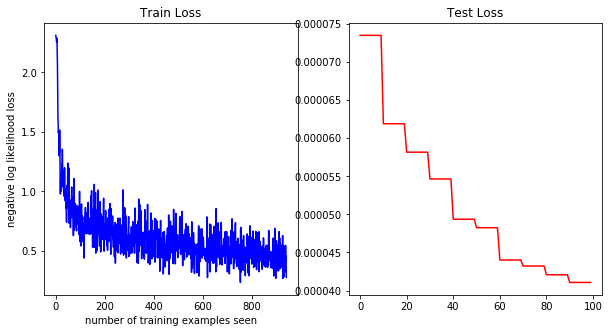

In [29]:
# Show results

fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_losses, color='blue')
plt.title('Train Loss')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

plt.subplot(1,2,2)
plt.title('Test Loss')
plt.plot(test_losses, color='red')

In [30]:
from itertools import chain

predictions_l = [test_predictions[i].tolist() for i in range(len(test_predictions))]
labels_l = [test_labels[i].tolist() for i in range(len(test_labels))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))

# Fix to make it run in lab
predictions_l = np.ravel(predictions_l)
labels_l = np.ravel(labels_l)

In [31]:
confusion_matrix(labels_l, predictions_l)

print("Classification report for CNN :\n%s\n"
      % (classification_report(labels_l, predictions_l)))

Classification report for CNN :
              precision    recall  f1-score   support

           0       0.72      0.82      0.77     10000
           1       0.94      0.95      0.94     10000
           2       0.67      0.68      0.67     10000
           3       0.83      0.81      0.82     10000
           4       0.64      0.76      0.69     10000
           5       0.94      0.89      0.92     10000
           6       0.56      0.38      0.45     10000
           7       0.86      0.92      0.89     10000
           8       0.94      0.93      0.94     10000
           9       0.92      0.93      0.92     10000

    accuracy                           0.81    100000
   macro avg       0.80      0.81      0.80    100000
weighted avg       0.80      0.81      0.80    100000




# Exercici 3: Kaggle Car Dataset [Opcional]

Trobar el model de cotxe en el Standford Car Dataset. El Dataset consisteix en 16000 imatges i 196 models possibles

https://www.kaggle.com/jutrera/stanford-car-dataset-by-classes-folder/download

Donar l'accuracy de l'algoritme sobre el conjunt de test i la matriu de confusió. Mostrar també l'evolució del loss d'entrenament i validació al llarg de les iteracions

Es recomana fer servir transfer learning per tal de millorar els resultats de classificació

NOTA: Cal descomprimir el fitxer stanford-car-dataset.zip en l'equip local el primer cop. Cal ajustar la variable per a que trobi el dataset

NOTA2: S'ha modificat el dataset per treballar amb imatges de mida 224x224 (la mida de les imatges ImageNET), per tal de poder treballar millor el transfer learning. També s'ha reduit el nombre de classes per tal de poder treballar amb les màquines del SOC


In [32]:
import os
import copy
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dataset_dir = 'car_dataset/car_data/car_data/'
train_dir = os.path.join(dataset_dir,'train')
test_dir = os.path.join(dataset_dir,'test')

# transformacio standard ImageNet
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


batch_size=12
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Loading datasets into dataloader 
dataloaders = {'train': DataLoader(train_dataset, batch_size = batch_size, shuffle = True),
               'test': DataLoader(test_dataset, batch_size = batch_size, shuffle = False)}

dataset_sizes = {'train': len(train_dataset),
                 'test': len(test_dataset)}

class_names = train_dataset.classes

print("Total Number of Samples: ",len(train_dataset) + len(test_dataset))
print("Number of Samples in Train: ",len(train_dataset))
print("Number of Samples in Test: ",len(test_dataset))
print("Number of Classes: ",len(train_dataset.classes))
print("Classes: ", class_names)

Total Number of Samples:  1630
Number of Samples in Train:  819
Number of Samples in Test:  811
Number of Classes:  20
Classes:  ['AM General Hummer SUV 2000', 'Acura Integra Type R 2001', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012', 'Acura ZDX Hatchback 2012', 'Aston Martin V8 Vantage Convertible 2012', 'Aston Martin V8 Vantage Coupe 2012', 'Aston Martin Virage Convertible 2012', 'Aston Martin Virage Coupe 2012', 'Audi 100 Sedan 1994', 'Audi 100 Wagon 1994', 'Audi A5 Coupe 2012', 'Audi R8 Coupe 2012', 'Audi RS 4 Convertible 2008', 'Audi S4 Sedan 2007', 'Audi S4 Sedan 2012', 'Audi S5 Convertible 2012', 'Audi S5 Coupe 2012']


 Sizes of Datasets:  811 819


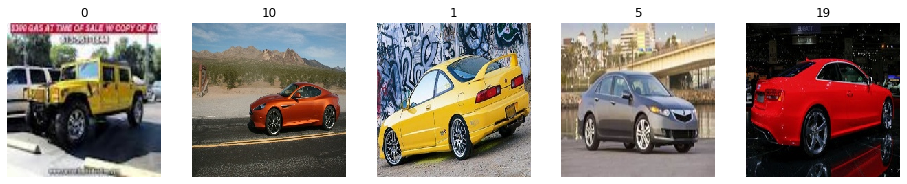

In [33]:
## Method to display Image for Tensor
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax


print(" Sizes of Datasets: ", len(test_dataset), len(train_dataset))

# Displaying Training Images
images, labels = next(iter(dataloaders['train']))

fig, axes = plt.subplots(figsize=(16,5), ncols=5)
for ii in range(5):
    ax = axes[ii]
    ax.set_title(labels[ii].item())
    imshow(images[ii], ax=ax, normalize=True)
    

In [34]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from torchvision import datasets, transforms, models

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

TRAIN_FOLDER_PATH = 'car_dataset/car_data/car_data/train'
TEST_FOLDER_PATH = 'car_dataset/car_data/car_data/test'

In [36]:
# Tranformations
train_transform = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(15),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [37]:
# Load datasets

train_dataset = datasets.ImageFolder(TRAIN_FOLDER_PATH, transform=train_transform)
test_dataset = datasets.ImageFolder(TEST_FOLDER_PATH, transform=test_transform)

In [38]:
# Create the DataLoaders

batch_size = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size) 

In [39]:
# Create model

#from efficientnet_pytorch import EfficientNet
#model_ft = EfficientNet.from_pretrained('efficientnet-b0', num_classes=20) 

model_ft = models.resnet18(pretrained=True)
#model_ft = models.resnet152(pretrained=True)
#model_ft = models.mobilenet_v2()

# Freeze weights
for param in model_ft.parameters():
    param.requires_grad = False
    
num_features = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_features, 20)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

#optimizer = optim.SGD(model_ft.fc.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9)

In [40]:
def print_message(msg, show=True):
    if show:
        print(msg)

In [41]:
def train():
    model_ft.train()
    
    total_correct = 0.0
    total_loss = 0.0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()
        output = model_ft(data)
        _, predicted = torch.max(output.data, 1)
        
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss
        total_correct += (predicted == target ).float().sum()
        
        print_message("[Train] [{} / {}]\tLoss: {:.4f}".format(
            (batch_idx * len(data)),
            len(train_dataset),
            loss), True)
        
    scheduler.step()
    
    epoch_acc = (100 * total_correct) / len(train_dataset)
    epoch_loss = (100 * total_loss) / len(train_dataset)
    
    print_message("[Train] Loss: {:.4f}, Acc: {:.4f}".format(epoch_loss,  epoch_acc), False)
    
    return epoch_loss, epoch_acc

In [42]:
def test():
    model_ft.eval()
    
    total_correct = 0.0
    total_loss = 0.0
    
    predictions = []
    labels = []
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data = data.to(device)
            target = target.to(device)
            
            labels.append(target)
            
            output = model_ft(data)
            _, predicted = torch.max(output.data, 1)
            
            loss = criterion(output, target)
            
            predictions.append(predicted)
            total_loss += loss
            total_correct += (predicted == target ).float().sum()
            
            print_message("[Test] [{} / {}]\tAcc: {:.2f}%".format(
                (batch_idx * len(data)),
                len(test_dataset),
                (100 * total_correct) / len(test_dataset)), True)
        
        epoch_acc = (100 * total_correct) / len(test_dataset)
        epoch_loss = (100 * total_loss) / len(test_dataset)
        
        print_message("[Test] Loss: {:.4f}, Acc: {:.4f}".format(epoch_loss, epoch_acc), False)
        
        return epoch_loss, epoch_acc, labels, predictions

In [43]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
test_predictions = []
test_labels = []

for i in range(1, 25):
    print("Epoch {}".format(i))
    
    loss_train, acc_train = train()
    loss_test, acc_test, t_labels, t_preds = test()
    
    train_losses.append(loss_train)
    train_accuracies.append(acc_train)
    
    test_losses.append(loss_test)
    test_accuracies.append(acc_test)
    test_predictions.extend(t_preds)
    test_labels.extend(t_labels)

Epoch 1
[Train] [0 / 819]	Loss: 3.3620
[Train] [4 / 819]	Loss: 3.3319
[Train] [8 / 819]	Loss: 3.3569
[Train] [12 / 819]	Loss: 3.6766
[Train] [16 / 819]	Loss: 3.9908
[Train] [20 / 819]	Loss: 5.3664
[Train] [24 / 819]	Loss: 5.0953
[Train] [28 / 819]	Loss: 4.2535
[Train] [32 / 819]	Loss: 4.2922
[Train] [36 / 819]	Loss: 4.6962
[Train] [40 / 819]	Loss: 3.1270
[Train] [44 / 819]	Loss: 5.7319
[Train] [48 / 819]	Loss: 8.6326
[Train] [52 / 819]	Loss: 4.5161
[Train] [56 / 819]	Loss: 5.8443
[Train] [60 / 819]	Loss: 4.3680
[Train] [64 / 819]	Loss: 5.3910
[Train] [68 / 819]	Loss: 5.5500
[Train] [72 / 819]	Loss: 1.6296
[Train] [76 / 819]	Loss: 7.7864
[Train] [80 / 819]	Loss: 6.1620
[Train] [84 / 819]	Loss: 5.8196
[Train] [88 / 819]	Loss: 8.5880
[Train] [92 / 819]	Loss: 9.6287
[Train] [96 / 819]	Loss: 5.2125
[Train] [100 / 819]	Loss: 4.0219
[Train] [104 / 819]	Loss: 8.0171
[Train] [108 / 819]	Loss: 5.5930
[Train] [112 / 819]	Loss: 4.1275
[Train] [116 / 819]	Loss: 5.0111
[Train] [120 / 819]	Loss: 5.64

[Test] [208 / 811]	Acc: 6.17%
[Test] [212 / 811]	Acc: 6.29%
[Test] [216 / 811]	Acc: 6.54%
[Test] [220 / 811]	Acc: 7.03%
[Test] [224 / 811]	Acc: 7.27%
[Test] [228 / 811]	Acc: 7.40%
[Test] [232 / 811]	Acc: 7.52%
[Test] [236 / 811]	Acc: 7.77%
[Test] [240 / 811]	Acc: 8.01%
[Test] [244 / 811]	Acc: 8.14%
[Test] [248 / 811]	Acc: 8.14%
[Test] [252 / 811]	Acc: 8.14%
[Test] [256 / 811]	Acc: 8.14%
[Test] [260 / 811]	Acc: 8.14%
[Test] [264 / 811]	Acc: 8.14%
[Test] [268 / 811]	Acc: 8.14%
[Test] [272 / 811]	Acc: 8.14%
[Test] [276 / 811]	Acc: 8.14%
[Test] [280 / 811]	Acc: 8.14%
[Test] [284 / 811]	Acc: 8.14%
[Test] [288 / 811]	Acc: 8.14%
[Test] [292 / 811]	Acc: 8.14%
[Test] [296 / 811]	Acc: 8.14%
[Test] [300 / 811]	Acc: 8.14%
[Test] [304 / 811]	Acc: 8.14%
[Test] [308 / 811]	Acc: 8.14%
[Test] [312 / 811]	Acc: 8.14%
[Test] [316 / 811]	Acc: 8.14%
[Test] [320 / 811]	Acc: 8.14%
[Test] [324 / 811]	Acc: 8.14%
[Test] [328 / 811]	Acc: 8.38%
[Test] [332 / 811]	Acc: 8.75%
[Test] [336 / 811]	Acc: 9.00%
[Test] [34

[Train] [472 / 819]	Loss: 2.4204
[Train] [476 / 819]	Loss: 4.7582
[Train] [480 / 819]	Loss: 8.0208
[Train] [484 / 819]	Loss: 4.1317
[Train] [488 / 819]	Loss: 3.2780
[Train] [492 / 819]	Loss: 4.5067
[Train] [496 / 819]	Loss: 7.8003
[Train] [500 / 819]	Loss: 7.1966
[Train] [504 / 819]	Loss: 5.0373
[Train] [508 / 819]	Loss: 4.5238
[Train] [512 / 819]	Loss: 3.6260
[Train] [516 / 819]	Loss: 6.6846
[Train] [520 / 819]	Loss: 4.4650
[Train] [524 / 819]	Loss: 6.4588
[Train] [528 / 819]	Loss: 6.7127
[Train] [532 / 819]	Loss: 23.1487
[Train] [536 / 819]	Loss: 5.3095
[Train] [540 / 819]	Loss: 11.7035
[Train] [544 / 819]	Loss: 2.4928
[Train] [548 / 819]	Loss: 0.9201
[Train] [552 / 819]	Loss: 3.8733
[Train] [556 / 819]	Loss: 2.9563
[Train] [560 / 819]	Loss: 5.0963
[Train] [564 / 819]	Loss: 8.9239
[Train] [568 / 819]	Loss: 6.2498
[Train] [572 / 819]	Loss: 6.8394
[Train] [576 / 819]	Loss: 13.3702
[Train] [580 / 819]	Loss: 9.2104
[Train] [584 / 819]	Loss: 6.3624
[Train] [588 / 819]	Loss: 2.7215
[Train]

[Test] [704 / 811]	Acc: 27.37%
[Test] [708 / 811]	Acc: 27.37%
[Test] [712 / 811]	Acc: 27.50%
[Test] [716 / 811]	Acc: 27.50%
[Test] [720 / 811]	Acc: 27.62%
[Test] [724 / 811]	Acc: 27.74%
[Test] [728 / 811]	Acc: 27.99%
[Test] [732 / 811]	Acc: 28.36%
[Test] [736 / 811]	Acc: 28.85%
[Test] [740 / 811]	Acc: 29.10%
[Test] [744 / 811]	Acc: 29.22%
[Test] [748 / 811]	Acc: 29.59%
[Test] [752 / 811]	Acc: 29.96%
[Test] [756 / 811]	Acc: 30.33%
[Test] [760 / 811]	Acc: 30.58%
[Test] [764 / 811]	Acc: 30.95%
[Test] [768 / 811]	Acc: 31.07%
[Test] [772 / 811]	Acc: 31.07%
[Test] [776 / 811]	Acc: 31.07%
[Test] [780 / 811]	Acc: 31.32%
[Test] [784 / 811]	Acc: 31.44%
[Test] [788 / 811]	Acc: 31.57%
[Test] [792 / 811]	Acc: 31.69%
[Test] [796 / 811]	Acc: 31.81%
[Test] [800 / 811]	Acc: 32.06%
[Test] [804 / 811]	Acc: 32.18%
[Test] [606 / 811]	Acc: 32.18%
Epoch 3
[Train] [0 / 819]	Loss: 1.7929
[Train] [4 / 819]	Loss: 5.3010
[Train] [8 / 819]	Loss: 5.5659
[Train] [12 / 819]	Loss: 6.5112
[Train] [16 / 819]	Loss: 5.292

[Test] [112 / 811]	Acc: 7.03%
[Test] [116 / 811]	Acc: 7.03%
[Test] [120 / 811]	Acc: 7.40%
[Test] [124 / 811]	Acc: 7.77%
[Test] [128 / 811]	Acc: 8.01%
[Test] [132 / 811]	Acc: 8.38%
[Test] [136 / 811]	Acc: 8.75%
[Test] [140 / 811]	Acc: 8.88%
[Test] [144 / 811]	Acc: 9.25%
[Test] [148 / 811]	Acc: 9.37%
[Test] [152 / 811]	Acc: 9.62%
[Test] [156 / 811]	Acc: 9.74%
[Test] [160 / 811]	Acc: 9.86%
[Test] [164 / 811]	Acc: 9.99%
[Test] [168 / 811]	Acc: 10.23%
[Test] [172 / 811]	Acc: 10.36%
[Test] [176 / 811]	Acc: 10.36%
[Test] [180 / 811]	Acc: 10.48%
[Test] [184 / 811]	Acc: 10.48%
[Test] [188 / 811]	Acc: 10.73%
[Test] [192 / 811]	Acc: 10.97%
[Test] [196 / 811]	Acc: 11.22%
[Test] [200 / 811]	Acc: 11.34%
[Test] [204 / 811]	Acc: 11.47%
[Test] [208 / 811]	Acc: 11.47%
[Test] [212 / 811]	Acc: 11.47%
[Test] [216 / 811]	Acc: 11.47%
[Test] [220 / 811]	Acc: 11.47%
[Test] [224 / 811]	Acc: 11.47%
[Test] [228 / 811]	Acc: 11.47%
[Test] [232 / 811]	Acc: 11.47%
[Test] [236 / 811]	Acc: 11.47%
[Test] [240 / 811]	Acc

[Train] [384 / 819]	Loss: 3.8801
[Train] [388 / 819]	Loss: 3.3884
[Train] [392 / 819]	Loss: 9.3715
[Train] [396 / 819]	Loss: 3.2369
[Train] [400 / 819]	Loss: 5.4679
[Train] [404 / 819]	Loss: 4.2069
[Train] [408 / 819]	Loss: 3.4358
[Train] [412 / 819]	Loss: 3.2450
[Train] [416 / 819]	Loss: 2.5728
[Train] [420 / 819]	Loss: 0.1323
[Train] [424 / 819]	Loss: 5.0139
[Train] [428 / 819]	Loss: 4.6998
[Train] [432 / 819]	Loss: 5.9795
[Train] [436 / 819]	Loss: 9.0447
[Train] [440 / 819]	Loss: 8.3450
[Train] [444 / 819]	Loss: 5.6329
[Train] [448 / 819]	Loss: 5.0760
[Train] [452 / 819]	Loss: 7.8114
[Train] [456 / 819]	Loss: 2.0183
[Train] [460 / 819]	Loss: 1.8138
[Train] [464 / 819]	Loss: 5.9295
[Train] [468 / 819]	Loss: 4.5975
[Train] [472 / 819]	Loss: 4.0224
[Train] [476 / 819]	Loss: 1.4201
[Train] [480 / 819]	Loss: 4.5169
[Train] [484 / 819]	Loss: 4.6797
[Train] [488 / 819]	Loss: 3.7367
[Train] [492 / 819]	Loss: 3.4668
[Train] [496 / 819]	Loss: 4.4667
[Train] [500 / 819]	Loss: 6.4820
[Train] [5

[Test] [636 / 811]	Acc: 26.39%
[Test] [640 / 811]	Acc: 26.39%
[Test] [644 / 811]	Acc: 26.51%
[Test] [648 / 811]	Acc: 26.51%
[Test] [652 / 811]	Acc: 26.63%
[Test] [656 / 811]	Acc: 26.63%
[Test] [660 / 811]	Acc: 26.76%
[Test] [664 / 811]	Acc: 26.76%
[Test] [668 / 811]	Acc: 27.00%
[Test] [672 / 811]	Acc: 27.13%
[Test] [676 / 811]	Acc: 27.25%
[Test] [680 / 811]	Acc: 27.25%
[Test] [684 / 811]	Acc: 27.37%
[Test] [688 / 811]	Acc: 27.74%
[Test] [692 / 811]	Acc: 27.87%
[Test] [696 / 811]	Acc: 28.11%
[Test] [700 / 811]	Acc: 28.24%
[Test] [704 / 811]	Acc: 28.36%
[Test] [708 / 811]	Acc: 28.48%
[Test] [712 / 811]	Acc: 28.73%
[Test] [716 / 811]	Acc: 28.73%
[Test] [720 / 811]	Acc: 28.85%
[Test] [724 / 811]	Acc: 28.98%
[Test] [728 / 811]	Acc: 29.10%
[Test] [732 / 811]	Acc: 29.22%
[Test] [736 / 811]	Acc: 29.47%
[Test] [740 / 811]	Acc: 29.47%
[Test] [744 / 811]	Acc: 29.47%
[Test] [748 / 811]	Acc: 29.47%
[Test] [752 / 811]	Acc: 29.72%
[Test] [756 / 811]	Acc: 29.84%
[Test] [760 / 811]	Acc: 29.96%
[Test] [

[Test] [20 / 811]	Acc: 2.96%
[Test] [24 / 811]	Acc: 3.45%
[Test] [28 / 811]	Acc: 3.95%
[Test] [32 / 811]	Acc: 4.44%
[Test] [36 / 811]	Acc: 4.93%
[Test] [40 / 811]	Acc: 5.43%
[Test] [44 / 811]	Acc: 5.55%
[Test] [48 / 811]	Acc: 5.92%
[Test] [52 / 811]	Acc: 6.17%
[Test] [56 / 811]	Acc: 6.17%
[Test] [60 / 811]	Acc: 6.54%
[Test] [64 / 811]	Acc: 6.78%
[Test] [68 / 811]	Acc: 7.15%
[Test] [72 / 811]	Acc: 7.27%
[Test] [76 / 811]	Acc: 7.40%
[Test] [80 / 811]	Acc: 7.89%
[Test] [84 / 811]	Acc: 8.14%
[Test] [88 / 811]	Acc: 8.14%
[Test] [92 / 811]	Acc: 8.26%
[Test] [96 / 811]	Acc: 8.26%
[Test] [100 / 811]	Acc: 8.26%
[Test] [104 / 811]	Acc: 8.26%
[Test] [108 / 811]	Acc: 8.26%
[Test] [112 / 811]	Acc: 8.26%
[Test] [116 / 811]	Acc: 8.26%
[Test] [120 / 811]	Acc: 8.63%
[Test] [124 / 811]	Acc: 8.88%
[Test] [128 / 811]	Acc: 9.00%
[Test] [132 / 811]	Acc: 9.37%
[Test] [136 / 811]	Acc: 9.62%
[Test] [140 / 811]	Acc: 9.99%
[Test] [144 / 811]	Acc: 10.48%
[Test] [148 / 811]	Acc: 10.73%
[Test] [152 / 811]	Acc: 11.1

[Train] [284 / 819]	Loss: 5.1006
[Train] [288 / 819]	Loss: 2.0122
[Train] [292 / 819]	Loss: 7.6660
[Train] [296 / 819]	Loss: 2.1894
[Train] [300 / 819]	Loss: 5.1890
[Train] [304 / 819]	Loss: 2.8968
[Train] [308 / 819]	Loss: 7.7690
[Train] [312 / 819]	Loss: 8.3808
[Train] [316 / 819]	Loss: 2.5378
[Train] [320 / 819]	Loss: 1.5703
[Train] [324 / 819]	Loss: 4.6799
[Train] [328 / 819]	Loss: 4.8560
[Train] [332 / 819]	Loss: 5.1927
[Train] [336 / 819]	Loss: 2.6478
[Train] [340 / 819]	Loss: 9.0727
[Train] [344 / 819]	Loss: 5.3131
[Train] [348 / 819]	Loss: 0.1697
[Train] [352 / 819]	Loss: 10.9607
[Train] [356 / 819]	Loss: 1.7810
[Train] [360 / 819]	Loss: 10.9130
[Train] [364 / 819]	Loss: 2.8216
[Train] [368 / 819]	Loss: 4.4559
[Train] [372 / 819]	Loss: 4.3256
[Train] [376 / 819]	Loss: 4.3342
[Train] [380 / 819]	Loss: 7.6195
[Train] [384 / 819]	Loss: 5.9264
[Train] [388 / 819]	Loss: 8.8344
[Train] [392 / 819]	Loss: 7.2689
[Train] [396 / 819]	Loss: 1.5013
[Train] [400 / 819]	Loss: 4.0169
[Train] 

[Test] [532 / 811]	Acc: 27.87%
[Test] [536 / 811]	Acc: 28.24%
[Test] [540 / 811]	Acc: 28.61%
[Test] [544 / 811]	Acc: 29.10%
[Test] [548 / 811]	Acc: 29.47%
[Test] [552 / 811]	Acc: 29.72%
[Test] [556 / 811]	Acc: 30.21%
[Test] [560 / 811]	Acc: 30.46%
[Test] [564 / 811]	Acc: 30.46%
[Test] [568 / 811]	Acc: 30.46%
[Test] [572 / 811]	Acc: 30.46%
[Test] [576 / 811]	Acc: 30.46%
[Test] [580 / 811]	Acc: 30.46%
[Test] [584 / 811]	Acc: 30.46%
[Test] [588 / 811]	Acc: 30.46%
[Test] [592 / 811]	Acc: 30.46%
[Test] [596 / 811]	Acc: 30.46%
[Test] [600 / 811]	Acc: 30.46%
[Test] [604 / 811]	Acc: 30.46%
[Test] [608 / 811]	Acc: 30.46%
[Test] [612 / 811]	Acc: 30.46%
[Test] [616 / 811]	Acc: 30.70%
[Test] [620 / 811]	Acc: 30.95%
[Test] [624 / 811]	Acc: 31.07%
[Test] [628 / 811]	Acc: 31.32%
[Test] [632 / 811]	Acc: 31.32%
[Test] [636 / 811]	Acc: 31.44%
[Test] [640 / 811]	Acc: 31.44%
[Test] [644 / 811]	Acc: 31.69%
[Test] [648 / 811]	Acc: 31.94%
[Test] [652 / 811]	Acc: 32.06%
[Test] [656 / 811]	Acc: 32.18%
[Test] [

[Train] [744 / 819]	Loss: 2.8964
[Train] [748 / 819]	Loss: 4.3348
[Train] [752 / 819]	Loss: 5.5708
[Train] [756 / 819]	Loss: 4.5808
[Train] [760 / 819]	Loss: 5.9526
[Train] [764 / 819]	Loss: 5.4463
[Train] [768 / 819]	Loss: 5.0795
[Train] [772 / 819]	Loss: 4.5607
[Train] [776 / 819]	Loss: 4.2937
[Train] [780 / 819]	Loss: 5.0944
[Train] [784 / 819]	Loss: 4.4994
[Train] [788 / 819]	Loss: 0.8615
[Train] [792 / 819]	Loss: 3.1305
[Train] [796 / 819]	Loss: 4.7929
[Train] [800 / 819]	Loss: 1.4943
[Train] [804 / 819]	Loss: 1.7734
[Train] [808 / 819]	Loss: 7.5884
[Train] [812 / 819]	Loss: 5.0944
[Train] [612 / 819]	Loss: 5.3115
[Test] [0 / 811]	Acc: 0.49%
[Test] [4 / 811]	Acc: 0.86%
[Test] [8 / 811]	Acc: 1.36%
[Test] [12 / 811]	Acc: 1.85%
[Test] [16 / 811]	Acc: 2.34%
[Test] [20 / 811]	Acc: 2.71%
[Test] [24 / 811]	Acc: 3.21%
[Test] [28 / 811]	Acc: 3.70%
[Test] [32 / 811]	Acc: 4.19%
[Test] [36 / 811]	Acc: 4.69%
[Test] [40 / 811]	Acc: 5.18%
[Test] [44 / 811]	Acc: 5.43%
[Test] [48 / 811]	Acc: 5.92%

[Train] [168 / 819]	Loss: 4.5167
[Train] [172 / 819]	Loss: 1.5275
[Train] [176 / 819]	Loss: 4.9685
[Train] [180 / 819]	Loss: 6.8974
[Train] [184 / 819]	Loss: 6.7128
[Train] [188 / 819]	Loss: 4.7522
[Train] [192 / 819]	Loss: 5.7566
[Train] [196 / 819]	Loss: 8.5782
[Train] [200 / 819]	Loss: 0.4853
[Train] [204 / 819]	Loss: 3.9626
[Train] [208 / 819]	Loss: 5.9026
[Train] [212 / 819]	Loss: 7.6020
[Train] [216 / 819]	Loss: 0.2336
[Train] [220 / 819]	Loss: 6.0948
[Train] [224 / 819]	Loss: 1.3448
[Train] [228 / 819]	Loss: 8.8370
[Train] [232 / 819]	Loss: 2.8067
[Train] [236 / 819]	Loss: 3.8663
[Train] [240 / 819]	Loss: 1.9791
[Train] [244 / 819]	Loss: 4.3696
[Train] [248 / 819]	Loss: 7.2684
[Train] [252 / 819]	Loss: 2.2200
[Train] [256 / 819]	Loss: 2.6467
[Train] [260 / 819]	Loss: 0.6042
[Train] [264 / 819]	Loss: 8.5082
[Train] [268 / 819]	Loss: 10.1382
[Train] [272 / 819]	Loss: 7.7587
[Train] [276 / 819]	Loss: 4.5230
[Train] [280 / 819]	Loss: 6.0330
[Train] [284 / 819]	Loss: 6.9604
[Train] [

[Test] [412 / 811]	Acc: 21.09%
[Test] [416 / 811]	Acc: 21.58%
[Test] [420 / 811]	Acc: 21.95%
[Test] [424 / 811]	Acc: 22.44%
[Test] [428 / 811]	Acc: 22.93%
[Test] [432 / 811]	Acc: 23.30%
[Test] [436 / 811]	Acc: 23.80%
[Test] [440 / 811]	Acc: 24.29%
[Test] [444 / 811]	Acc: 24.66%
[Test] [448 / 811]	Acc: 25.03%
[Test] [452 / 811]	Acc: 25.52%
[Test] [456 / 811]	Acc: 26.02%
[Test] [460 / 811]	Acc: 26.51%
[Test] [464 / 811]	Acc: 27.00%
[Test] [468 / 811]	Acc: 27.50%
[Test] [472 / 811]	Acc: 27.99%
[Test] [476 / 811]	Acc: 28.48%
[Test] [480 / 811]	Acc: 28.61%
[Test] [484 / 811]	Acc: 28.61%
[Test] [488 / 811]	Acc: 28.61%
[Test] [492 / 811]	Acc: 28.73%
[Test] [496 / 811]	Acc: 28.73%
[Test] [500 / 811]	Acc: 28.85%
[Test] [504 / 811]	Acc: 28.98%
[Test] [508 / 811]	Acc: 28.98%
[Test] [512 / 811]	Acc: 28.98%
[Test] [516 / 811]	Acc: 28.98%
[Test] [520 / 811]	Acc: 29.10%
[Test] [524 / 811]	Acc: 29.10%
[Test] [528 / 811]	Acc: 29.22%
[Test] [532 / 811]	Acc: 29.22%
[Test] [536 / 811]	Acc: 29.35%
[Test] [

[Train] [656 / 819]	Loss: 0.6546
[Train] [660 / 819]	Loss: 5.0339
[Train] [664 / 819]	Loss: 2.9853
[Train] [668 / 819]	Loss: 2.7556
[Train] [672 / 819]	Loss: 0.8302
[Train] [676 / 819]	Loss: 6.9629
[Train] [680 / 819]	Loss: 10.7784
[Train] [684 / 819]	Loss: 3.8818
[Train] [688 / 819]	Loss: 5.4432
[Train] [692 / 819]	Loss: 1.4785
[Train] [696 / 819]	Loss: 8.7460
[Train] [700 / 819]	Loss: 3.4427
[Train] [704 / 819]	Loss: 7.0959
[Train] [708 / 819]	Loss: 3.8920
[Train] [712 / 819]	Loss: 2.6728
[Train] [716 / 819]	Loss: 6.4846
[Train] [720 / 819]	Loss: 2.1305
[Train] [724 / 819]	Loss: 6.5519
[Train] [728 / 819]	Loss: 1.3815
[Train] [732 / 819]	Loss: 3.4300
[Train] [736 / 819]	Loss: 6.1683
[Train] [740 / 819]	Loss: 7.0523
[Train] [744 / 819]	Loss: 2.6467
[Train] [748 / 819]	Loss: 8.1564
[Train] [752 / 819]	Loss: 2.9460
[Train] [756 / 819]	Loss: 7.6560
[Train] [760 / 819]	Loss: 3.9104
[Train] [764 / 819]	Loss: 12.6698
[Train] [768 / 819]	Loss: 2.4934
[Train] [772 / 819]	Loss: 5.9626
[Train] 

[Train] [104 / 819]	Loss: 5.0166
[Train] [108 / 819]	Loss: 2.7058
[Train] [112 / 819]	Loss: 3.6936
[Train] [116 / 819]	Loss: 1.2782
[Train] [120 / 819]	Loss: 4.7806
[Train] [124 / 819]	Loss: 2.4055
[Train] [128 / 819]	Loss: 0.8822
[Train] [132 / 819]	Loss: 4.7928
[Train] [136 / 819]	Loss: 3.1360
[Train] [140 / 819]	Loss: 1.7105
[Train] [144 / 819]	Loss: 2.3291
[Train] [148 / 819]	Loss: 4.2503
[Train] [152 / 819]	Loss: 2.7012
[Train] [156 / 819]	Loss: 0.8443
[Train] [160 / 819]	Loss: 2.7429
[Train] [164 / 819]	Loss: 0.7993
[Train] [168 / 819]	Loss: 4.6362
[Train] [172 / 819]	Loss: 3.1595
[Train] [176 / 819]	Loss: 6.2949
[Train] [180 / 819]	Loss: 6.7914
[Train] [184 / 819]	Loss: 2.5292
[Train] [188 / 819]	Loss: 0.6413
[Train] [192 / 819]	Loss: 1.7052
[Train] [196 / 819]	Loss: 3.6797
[Train] [200 / 819]	Loss: 3.8088
[Train] [204 / 819]	Loss: 0.0120
[Train] [208 / 819]	Loss: 2.0147
[Train] [212 / 819]	Loss: 3.8703
[Train] [216 / 819]	Loss: 0.7784
[Train] [220 / 819]	Loss: 4.2650
[Train] [2

[Test] [324 / 811]	Acc: 15.66%
[Test] [328 / 811]	Acc: 15.91%
[Test] [332 / 811]	Acc: 16.03%
[Test] [336 / 811]	Acc: 16.15%
[Test] [340 / 811]	Acc: 16.15%
[Test] [344 / 811]	Acc: 16.52%
[Test] [348 / 811]	Acc: 16.65%
[Test] [352 / 811]	Acc: 16.77%
[Test] [356 / 811]	Acc: 16.77%
[Test] [360 / 811]	Acc: 16.77%
[Test] [364 / 811]	Acc: 16.77%
[Test] [368 / 811]	Acc: 16.89%
[Test] [372 / 811]	Acc: 17.26%
[Test] [376 / 811]	Acc: 17.51%
[Test] [380 / 811]	Acc: 17.76%
[Test] [384 / 811]	Acc: 18.13%
[Test] [388 / 811]	Acc: 18.50%
[Test] [392 / 811]	Acc: 18.62%
[Test] [396 / 811]	Acc: 18.99%
[Test] [400 / 811]	Acc: 19.36%
[Test] [404 / 811]	Acc: 19.85%
[Test] [408 / 811]	Acc: 20.10%
[Test] [412 / 811]	Acc: 20.35%
[Test] [416 / 811]	Acc: 20.84%
[Test] [420 / 811]	Acc: 21.09%
[Test] [424 / 811]	Acc: 21.58%
[Test] [428 / 811]	Acc: 21.95%
[Test] [432 / 811]	Acc: 22.32%
[Test] [436 / 811]	Acc: 22.81%
[Test] [440 / 811]	Acc: 23.18%
[Test] [444 / 811]	Acc: 23.30%
[Test] [448 / 811]	Acc: 23.43%
[Test] [

[Train] [580 / 819]	Loss: 3.7224
[Train] [584 / 819]	Loss: 2.3267
[Train] [588 / 819]	Loss: 0.3536
[Train] [592 / 819]	Loss: 7.7637
[Train] [596 / 819]	Loss: 6.2113
[Train] [600 / 819]	Loss: 0.6936
[Train] [604 / 819]	Loss: 3.9113
[Train] [608 / 819]	Loss: 3.5450
[Train] [612 / 819]	Loss: 1.8004
[Train] [616 / 819]	Loss: 4.2820
[Train] [620 / 819]	Loss: 0.0275
[Train] [624 / 819]	Loss: 7.8952
[Train] [628 / 819]	Loss: 5.4122
[Train] [632 / 819]	Loss: 2.7662
[Train] [636 / 819]	Loss: 3.9389
[Train] [640 / 819]	Loss: 4.2619
[Train] [644 / 819]	Loss: 4.8539
[Train] [648 / 819]	Loss: 3.4015
[Train] [652 / 819]	Loss: 8.1298
[Train] [656 / 819]	Loss: 0.5892
[Train] [660 / 819]	Loss: 0.4786
[Train] [664 / 819]	Loss: 1.1775
[Train] [668 / 819]	Loss: 3.3080
[Train] [672 / 819]	Loss: 4.5281
[Train] [676 / 819]	Loss: 2.9701
[Train] [680 / 819]	Loss: 3.7437
[Train] [684 / 819]	Loss: 8.8703
[Train] [688 / 819]	Loss: 4.5531
[Train] [692 / 819]	Loss: 3.9428
[Train] [696 / 819]	Loss: 8.1569
[Train] [7

[Test] [606 / 811]	Acc: 38.72%
Epoch 12
[Train] [0 / 819]	Loss: 1.3928
[Train] [4 / 819]	Loss: 2.3739
[Train] [8 / 819]	Loss: 4.9732
[Train] [12 / 819]	Loss: 7.1085
[Train] [16 / 819]	Loss: 4.5544
[Train] [20 / 819]	Loss: 2.7927
[Train] [24 / 819]	Loss: 0.9722
[Train] [28 / 819]	Loss: 6.7730
[Train] [32 / 819]	Loss: 6.9594
[Train] [36 / 819]	Loss: 0.2769
[Train] [40 / 819]	Loss: 1.6024
[Train] [44 / 819]	Loss: 3.6845
[Train] [48 / 819]	Loss: 2.3709
[Train] [52 / 819]	Loss: 1.1533
[Train] [56 / 819]	Loss: 1.1239
[Train] [60 / 819]	Loss: 8.8485
[Train] [64 / 819]	Loss: 4.5759
[Train] [68 / 819]	Loss: 4.4162
[Train] [72 / 819]	Loss: 5.5662
[Train] [76 / 819]	Loss: 3.0363
[Train] [80 / 819]	Loss: 3.1498
[Train] [84 / 819]	Loss: 6.3902
[Train] [88 / 819]	Loss: 6.7094
[Train] [92 / 819]	Loss: 4.3434
[Train] [96 / 819]	Loss: 4.6459
[Train] [100 / 819]	Loss: 3.4298
[Train] [104 / 819]	Loss: 8.0093
[Train] [108 / 819]	Loss: 4.6063
[Train] [112 / 819]	Loss: 2.4659
[Train] [116 / 819]	Loss: 11.35

[Test] [212 / 811]	Acc: 13.44%
[Test] [216 / 811]	Acc: 13.56%
[Test] [220 / 811]	Acc: 13.93%
[Test] [224 / 811]	Acc: 14.43%
[Test] [228 / 811]	Acc: 14.43%
[Test] [232 / 811]	Acc: 14.55%
[Test] [236 / 811]	Acc: 14.80%
[Test] [240 / 811]	Acc: 15.04%
[Test] [244 / 811]	Acc: 15.17%
[Test] [248 / 811]	Acc: 15.54%
[Test] [252 / 811]	Acc: 15.66%
[Test] [256 / 811]	Acc: 16.03%
[Test] [260 / 811]	Acc: 16.15%
[Test] [264 / 811]	Acc: 16.40%
[Test] [268 / 811]	Acc: 16.89%
[Test] [272 / 811]	Acc: 17.02%
[Test] [276 / 811]	Acc: 17.02%
[Test] [280 / 811]	Acc: 17.39%
[Test] [284 / 811]	Acc: 17.39%
[Test] [288 / 811]	Acc: 17.39%
[Test] [292 / 811]	Acc: 17.63%
[Test] [296 / 811]	Acc: 17.76%
[Test] [300 / 811]	Acc: 17.76%
[Test] [304 / 811]	Acc: 17.88%
[Test] [308 / 811]	Acc: 18.00%
[Test] [312 / 811]	Acc: 18.25%
[Test] [316 / 811]	Acc: 18.62%
[Test] [320 / 811]	Acc: 18.74%
[Test] [324 / 811]	Acc: 18.87%
[Test] [328 / 811]	Acc: 18.87%
[Test] [332 / 811]	Acc: 18.87%
[Test] [336 / 811]	Acc: 18.87%
[Test] [

[Train] [436 / 819]	Loss: 0.0235
[Train] [440 / 819]	Loss: 0.1702
[Train] [444 / 819]	Loss: 0.0945
[Train] [448 / 819]	Loss: 4.8137
[Train] [452 / 819]	Loss: 5.7122
[Train] [456 / 819]	Loss: 1.6129
[Train] [460 / 819]	Loss: 4.2021
[Train] [464 / 819]	Loss: 2.9272
[Train] [468 / 819]	Loss: 3.9469
[Train] [472 / 819]	Loss: 0.2007
[Train] [476 / 819]	Loss: 1.5895
[Train] [480 / 819]	Loss: 0.6165
[Train] [484 / 819]	Loss: 3.6645
[Train] [488 / 819]	Loss: 0.5427
[Train] [492 / 819]	Loss: 1.0142
[Train] [496 / 819]	Loss: 3.5830
[Train] [500 / 819]	Loss: 2.3705
[Train] [504 / 819]	Loss: 7.8320
[Train] [508 / 819]	Loss: 0.5548
[Train] [512 / 819]	Loss: 3.5076
[Train] [516 / 819]	Loss: 0.3175
[Train] [520 / 819]	Loss: 3.0422
[Train] [524 / 819]	Loss: 4.0140
[Train] [528 / 819]	Loss: 0.1649
[Train] [532 / 819]	Loss: 1.9590
[Train] [536 / 819]	Loss: 1.7715
[Train] [540 / 819]	Loss: 5.7521
[Train] [544 / 819]	Loss: 5.3293
[Train] [548 / 819]	Loss: 2.9158
[Train] [552 / 819]	Loss: 9.1347
[Train] [5

[Test] [672 / 811]	Acc: 37.11%
[Test] [676 / 811]	Acc: 37.11%
[Test] [680 / 811]	Acc: 37.11%
[Test] [684 / 811]	Acc: 37.11%
[Test] [688 / 811]	Acc: 37.61%
[Test] [692 / 811]	Acc: 37.73%
[Test] [696 / 811]	Acc: 37.85%
[Test] [700 / 811]	Acc: 37.98%
[Test] [704 / 811]	Acc: 38.35%
[Test] [708 / 811]	Acc: 38.59%
[Test] [712 / 811]	Acc: 38.72%
[Test] [716 / 811]	Acc: 38.96%
[Test] [720 / 811]	Acc: 39.33%
[Test] [724 / 811]	Acc: 39.70%
[Test] [728 / 811]	Acc: 39.83%
[Test] [732 / 811]	Acc: 39.95%
[Test] [736 / 811]	Acc: 40.20%
[Test] [740 / 811]	Acc: 40.44%
[Test] [744 / 811]	Acc: 40.57%
[Test] [748 / 811]	Acc: 40.57%
[Test] [752 / 811]	Acc: 40.94%
[Test] [756 / 811]	Acc: 41.06%
[Test] [760 / 811]	Acc: 41.31%
[Test] [764 / 811]	Acc: 41.31%
[Test] [768 / 811]	Acc: 41.31%
[Test] [772 / 811]	Acc: 41.31%
[Test] [776 / 811]	Acc: 41.43%
[Test] [780 / 811]	Acc: 41.43%
[Test] [784 / 811]	Acc: 41.43%
[Test] [788 / 811]	Acc: 41.43%
[Test] [792 / 811]	Acc: 41.43%
[Test] [796 / 811]	Acc: 41.43%
[Test] [

[Test] [56 / 811]	Acc: 6.41%
[Test] [60 / 811]	Acc: 6.78%
[Test] [64 / 811]	Acc: 6.91%
[Test] [68 / 811]	Acc: 7.15%
[Test] [72 / 811]	Acc: 7.15%
[Test] [76 / 811]	Acc: 7.27%
[Test] [80 / 811]	Acc: 7.64%
[Test] [84 / 811]	Acc: 7.89%
[Test] [88 / 811]	Acc: 7.89%
[Test] [92 / 811]	Acc: 8.14%
[Test] [96 / 811]	Acc: 8.38%
[Test] [100 / 811]	Acc: 8.38%
[Test] [104 / 811]	Acc: 8.38%
[Test] [108 / 811]	Acc: 8.38%
[Test] [112 / 811]	Acc: 8.38%
[Test] [116 / 811]	Acc: 8.38%
[Test] [120 / 811]	Acc: 8.75%
[Test] [124 / 811]	Acc: 8.75%
[Test] [128 / 811]	Acc: 8.75%
[Test] [132 / 811]	Acc: 9.12%
[Test] [136 / 811]	Acc: 9.49%
[Test] [140 / 811]	Acc: 9.62%
[Test] [144 / 811]	Acc: 9.86%
[Test] [148 / 811]	Acc: 10.11%
[Test] [152 / 811]	Acc: 10.36%
[Test] [156 / 811]	Acc: 10.60%
[Test] [160 / 811]	Acc: 10.73%
[Test] [164 / 811]	Acc: 10.97%
[Test] [168 / 811]	Acc: 11.34%
[Test] [172 / 811]	Acc: 11.59%
[Test] [176 / 811]	Acc: 11.59%
[Test] [180 / 811]	Acc: 11.84%
[Test] [184 / 811]	Acc: 12.21%
[Test] [188

[Train] [296 / 819]	Loss: 1.7422
[Train] [300 / 819]	Loss: 0.0234
[Train] [304 / 819]	Loss: 1.2828
[Train] [308 / 819]	Loss: 0.9111
[Train] [312 / 819]	Loss: 0.9142
[Train] [316 / 819]	Loss: 4.7267
[Train] [320 / 819]	Loss: 1.8171
[Train] [324 / 819]	Loss: 4.1227
[Train] [328 / 819]	Loss: 2.9077
[Train] [332 / 819]	Loss: 5.0387
[Train] [336 / 819]	Loss: 0.4698
[Train] [340 / 819]	Loss: 2.3570
[Train] [344 / 819]	Loss: 0.6420
[Train] [348 / 819]	Loss: 5.2042
[Train] [352 / 819]	Loss: 4.8502
[Train] [356 / 819]	Loss: 3.8727
[Train] [360 / 819]	Loss: 0.2431
[Train] [364 / 819]	Loss: 3.5142
[Train] [368 / 819]	Loss: 0.5750
[Train] [372 / 819]	Loss: 3.3728
[Train] [376 / 819]	Loss: 7.0490
[Train] [380 / 819]	Loss: 3.3092
[Train] [384 / 819]	Loss: 5.3118
[Train] [388 / 819]	Loss: 2.3165
[Train] [392 / 819]	Loss: 2.2961
[Train] [396 / 819]	Loss: 4.2277
[Train] [400 / 819]	Loss: 1.2825
[Train] [404 / 819]	Loss: 0.3629
[Train] [408 / 819]	Loss: 2.7026
[Train] [412 / 819]	Loss: 0.9865
[Train] [4

[Test] [560 / 811]	Acc: 29.22%
[Test] [564 / 811]	Acc: 29.59%
[Test] [568 / 811]	Acc: 29.72%
[Test] [572 / 811]	Acc: 29.84%
[Test] [576 / 811]	Acc: 30.21%
[Test] [580 / 811]	Acc: 30.46%
[Test] [584 / 811]	Acc: 30.58%
[Test] [588 / 811]	Acc: 30.95%
[Test] [592 / 811]	Acc: 31.20%
[Test] [596 / 811]	Acc: 31.44%
[Test] [600 / 811]	Acc: 31.81%
[Test] [604 / 811]	Acc: 31.94%
[Test] [608 / 811]	Acc: 31.94%
[Test] [612 / 811]	Acc: 32.06%
[Test] [616 / 811]	Acc: 32.31%
[Test] [620 / 811]	Acc: 32.31%
[Test] [624 / 811]	Acc: 32.43%
[Test] [628 / 811]	Acc: 32.68%
[Test] [632 / 811]	Acc: 32.80%
[Test] [636 / 811]	Acc: 33.17%
[Test] [640 / 811]	Acc: 33.29%
[Test] [644 / 811]	Acc: 33.42%
[Test] [648 / 811]	Acc: 33.54%
[Test] [652 / 811]	Acc: 33.54%
[Test] [656 / 811]	Acc: 33.54%
[Test] [660 / 811]	Acc: 33.54%
[Test] [664 / 811]	Acc: 33.54%
[Test] [668 / 811]	Acc: 33.54%
[Test] [672 / 811]	Acc: 33.66%
[Test] [676 / 811]	Acc: 33.66%
[Test] [680 / 811]	Acc: 33.66%
[Test] [684 / 811]	Acc: 33.79%
[Test] [

[Train] [764 / 819]	Loss: 2.0198
[Train] [768 / 819]	Loss: 1.1552
[Train] [772 / 819]	Loss: 7.1865
[Train] [776 / 819]	Loss: 1.3715
[Train] [780 / 819]	Loss: 2.3604
[Train] [784 / 819]	Loss: 3.9477
[Train] [788 / 819]	Loss: 0.7405
[Train] [792 / 819]	Loss: 0.7743
[Train] [796 / 819]	Loss: 0.0289
[Train] [800 / 819]	Loss: 5.2471
[Train] [804 / 819]	Loss: 5.8529
[Train] [808 / 819]	Loss: 1.7002
[Train] [812 / 819]	Loss: 4.0762
[Train] [612 / 819]	Loss: 3.7166
[Test] [0 / 811]	Acc: 0.49%
[Test] [4 / 811]	Acc: 0.86%
[Test] [8 / 811]	Acc: 1.36%
[Test] [12 / 811]	Acc: 1.85%
[Test] [16 / 811]	Acc: 2.34%
[Test] [20 / 811]	Acc: 2.71%
[Test] [24 / 811]	Acc: 3.08%
[Test] [28 / 811]	Acc: 3.58%
[Test] [32 / 811]	Acc: 4.07%
[Test] [36 / 811]	Acc: 4.56%
[Test] [40 / 811]	Acc: 5.06%
[Test] [44 / 811]	Acc: 5.30%
[Test] [48 / 811]	Acc: 5.80%
[Test] [52 / 811]	Acc: 6.04%
[Test] [56 / 811]	Acc: 6.04%
[Test] [60 / 811]	Acc: 6.41%
[Test] [64 / 811]	Acc: 6.54%
[Test] [68 / 811]	Acc: 6.78%
[Test] [72 / 811]	A

[Train] [236 / 819]	Loss: 1.8724
[Train] [240 / 819]	Loss: 1.7003
[Train] [244 / 819]	Loss: 0.9976
[Train] [248 / 819]	Loss: 3.8864
[Train] [252 / 819]	Loss: 1.2124
[Train] [256 / 819]	Loss: 4.5744
[Train] [260 / 819]	Loss: 1.1127
[Train] [264 / 819]	Loss: 4.7673
[Train] [268 / 819]	Loss: 0.4713
[Train] [272 / 819]	Loss: 7.7083
[Train] [276 / 819]	Loss: 1.2142
[Train] [280 / 819]	Loss: 3.9296
[Train] [284 / 819]	Loss: 1.1285
[Train] [288 / 819]	Loss: 2.9064
[Train] [292 / 819]	Loss: 3.9102
[Train] [296 / 819]	Loss: 5.0967
[Train] [300 / 819]	Loss: 4.2535
[Train] [304 / 819]	Loss: 2.9946
[Train] [308 / 819]	Loss: 1.2212
[Train] [312 / 819]	Loss: 1.6361
[Train] [316 / 819]	Loss: 2.1446
[Train] [320 / 819]	Loss: 0.1753
[Train] [324 / 819]	Loss: 2.4440
[Train] [328 / 819]	Loss: 1.9416
[Train] [332 / 819]	Loss: 0.9832
[Train] [336 / 819]	Loss: 0.7176
[Train] [340 / 819]	Loss: 0.3801
[Train] [344 / 819]	Loss: 2.2292
[Train] [348 / 819]	Loss: 2.0584
[Train] [352 / 819]	Loss: 3.4427
[Train] [3

[Test] [456 / 811]	Acc: 27.62%
[Test] [460 / 811]	Acc: 27.99%
[Test] [464 / 811]	Acc: 28.48%
[Test] [468 / 811]	Acc: 28.98%
[Test] [472 / 811]	Acc: 29.47%
[Test] [476 / 811]	Acc: 29.96%
[Test] [480 / 811]	Acc: 30.09%
[Test] [484 / 811]	Acc: 30.21%
[Test] [488 / 811]	Acc: 30.21%
[Test] [492 / 811]	Acc: 30.46%
[Test] [496 / 811]	Acc: 30.58%
[Test] [500 / 811]	Acc: 30.83%
[Test] [504 / 811]	Acc: 30.95%
[Test] [508 / 811]	Acc: 31.07%
[Test] [512 / 811]	Acc: 31.32%
[Test] [516 / 811]	Acc: 31.69%
[Test] [520 / 811]	Acc: 31.94%
[Test] [524 / 811]	Acc: 31.94%
[Test] [528 / 811]	Acc: 31.94%
[Test] [532 / 811]	Acc: 31.94%
[Test] [536 / 811]	Acc: 31.94%
[Test] [540 / 811]	Acc: 31.94%
[Test] [544 / 811]	Acc: 31.94%
[Test] [548 / 811]	Acc: 31.94%
[Test] [552 / 811]	Acc: 31.94%
[Test] [556 / 811]	Acc: 32.06%
[Test] [560 / 811]	Acc: 32.06%
[Test] [564 / 811]	Acc: 32.43%
[Test] [568 / 811]	Acc: 32.55%
[Test] [572 / 811]	Acc: 32.92%
[Test] [576 / 811]	Acc: 33.29%
[Test] [580 / 811]	Acc: 33.54%
[Test] [

[Train] [672 / 819]	Loss: 1.3714
[Train] [676 / 819]	Loss: 4.3480
[Train] [680 / 819]	Loss: 1.9317
[Train] [684 / 819]	Loss: 3.2959
[Train] [688 / 819]	Loss: 2.5879
[Train] [692 / 819]	Loss: 1.7146
[Train] [696 / 819]	Loss: 2.0246
[Train] [700 / 819]	Loss: 0.1627
[Train] [704 / 819]	Loss: 6.0282
[Train] [708 / 819]	Loss: 5.2630
[Train] [712 / 819]	Loss: 2.6010
[Train] [716 / 819]	Loss: 3.8660
[Train] [720 / 819]	Loss: 1.1875
[Train] [724 / 819]	Loss: 3.3679
[Train] [728 / 819]	Loss: 0.0513
[Train] [732 / 819]	Loss: 2.6208
[Train] [736 / 819]	Loss: 0.5392
[Train] [740 / 819]	Loss: 0.1814
[Train] [744 / 819]	Loss: 1.8608
[Train] [748 / 819]	Loss: 4.4344
[Train] [752 / 819]	Loss: 1.3803
[Train] [756 / 819]	Loss: 2.3716
[Train] [760 / 819]	Loss: 3.4576
[Train] [764 / 819]	Loss: 0.4938
[Train] [768 / 819]	Loss: 2.4205
[Train] [772 / 819]	Loss: 3.0136
[Train] [776 / 819]	Loss: 4.6385
[Train] [780 / 819]	Loss: 1.4326
[Train] [784 / 819]	Loss: 2.9067
[Train] [788 / 819]	Loss: 0.0019
[Train] [7

[Train] [108 / 819]	Loss: 2.0739
[Train] [112 / 819]	Loss: 3.2070
[Train] [116 / 819]	Loss: 3.2815
[Train] [120 / 819]	Loss: 1.7362
[Train] [124 / 819]	Loss: 3.0046
[Train] [128 / 819]	Loss: 1.4420
[Train] [132 / 819]	Loss: 0.8863
[Train] [136 / 819]	Loss: 0.1098
[Train] [140 / 819]	Loss: 2.4349
[Train] [144 / 819]	Loss: 0.0604
[Train] [148 / 819]	Loss: 2.6763
[Train] [152 / 819]	Loss: 5.7005
[Train] [156 / 819]	Loss: 0.6537
[Train] [160 / 819]	Loss: 3.3817
[Train] [164 / 819]	Loss: 0.1970
[Train] [168 / 819]	Loss: 3.1911
[Train] [172 / 819]	Loss: 4.4313
[Train] [176 / 819]	Loss: 1.5760
[Train] [180 / 819]	Loss: 0.0312
[Train] [184 / 819]	Loss: 3.3773
[Train] [188 / 819]	Loss: 3.2004
[Train] [192 / 819]	Loss: 0.8032
[Train] [196 / 819]	Loss: 0.5525
[Train] [200 / 819]	Loss: 5.7078
[Train] [204 / 819]	Loss: 2.2045
[Train] [208 / 819]	Loss: 1.9512
[Train] [212 / 819]	Loss: 2.8118
[Train] [216 / 819]	Loss: 1.7109
[Train] [220 / 819]	Loss: 0.9103
[Train] [224 / 819]	Loss: 1.7193
[Train] [2

[Test] [320 / 811]	Acc: 17.51%
[Test] [324 / 811]	Acc: 17.76%
[Test] [328 / 811]	Acc: 17.76%
[Test] [332 / 811]	Acc: 17.76%
[Test] [336 / 811]	Acc: 17.76%
[Test] [340 / 811]	Acc: 17.76%
[Test] [344 / 811]	Acc: 18.13%
[Test] [348 / 811]	Acc: 18.37%
[Test] [352 / 811]	Acc: 18.37%
[Test] [356 / 811]	Acc: 18.37%
[Test] [360 / 811]	Acc: 18.37%
[Test] [364 / 811]	Acc: 18.37%
[Test] [368 / 811]	Acc: 18.37%
[Test] [372 / 811]	Acc: 18.50%
[Test] [376 / 811]	Acc: 18.62%
[Test] [380 / 811]	Acc: 18.74%
[Test] [384 / 811]	Acc: 18.87%
[Test] [388 / 811]	Acc: 18.99%
[Test] [392 / 811]	Acc: 18.99%
[Test] [396 / 811]	Acc: 19.11%
[Test] [400 / 811]	Acc: 19.36%
[Test] [404 / 811]	Acc: 19.85%
[Test] [408 / 811]	Acc: 20.22%
[Test] [412 / 811]	Acc: 20.47%
[Test] [416 / 811]	Acc: 20.96%
[Test] [420 / 811]	Acc: 21.21%
[Test] [424 / 811]	Acc: 21.70%
[Test] [428 / 811]	Acc: 22.07%
[Test] [432 / 811]	Acc: 22.44%
[Test] [436 / 811]	Acc: 22.93%
[Test] [440 / 811]	Acc: 23.43%
[Test] [444 / 811]	Acc: 23.67%
[Test] [

[Train] [572 / 819]	Loss: 5.9700
[Train] [576 / 819]	Loss: 2.9523
[Train] [580 / 819]	Loss: 0.8031
[Train] [584 / 819]	Loss: 5.0391
[Train] [588 / 819]	Loss: 3.5467
[Train] [592 / 819]	Loss: 6.1808
[Train] [596 / 819]	Loss: 5.0377
[Train] [600 / 819]	Loss: 2.3114
[Train] [604 / 819]	Loss: 0.8712
[Train] [608 / 819]	Loss: 2.1505
[Train] [612 / 819]	Loss: 4.4078
[Train] [616 / 819]	Loss: 0.9710
[Train] [620 / 819]	Loss: 0.8770
[Train] [624 / 819]	Loss: 3.5123
[Train] [628 / 819]	Loss: 0.1080
[Train] [632 / 819]	Loss: 3.5428
[Train] [636 / 819]	Loss: 2.8393
[Train] [640 / 819]	Loss: 7.4090
[Train] [644 / 819]	Loss: 1.9505
[Train] [648 / 819]	Loss: 4.7500
[Train] [652 / 819]	Loss: 2.4609
[Train] [656 / 819]	Loss: 1.7699
[Train] [660 / 819]	Loss: 5.8700
[Train] [664 / 819]	Loss: 1.5674
[Train] [668 / 819]	Loss: 3.0618
[Train] [672 / 819]	Loss: 1.9490
[Train] [676 / 819]	Loss: 2.5830
[Train] [680 / 819]	Loss: 2.7581
[Train] [684 / 819]	Loss: 0.8697
[Train] [688 / 819]	Loss: 2.6703
[Train] [6

[Train] [32 / 819]	Loss: 4.5677
[Train] [36 / 819]	Loss: 1.2613
[Train] [40 / 819]	Loss: 0.9606
[Train] [44 / 819]	Loss: 2.2027
[Train] [48 / 819]	Loss: 0.4659
[Train] [52 / 819]	Loss: 0.6215
[Train] [56 / 819]	Loss: 9.5513
[Train] [60 / 819]	Loss: 1.7796
[Train] [64 / 819]	Loss: 3.4512
[Train] [68 / 819]	Loss: 2.2190
[Train] [72 / 819]	Loss: 2.7167
[Train] [76 / 819]	Loss: 2.2380
[Train] [80 / 819]	Loss: 0.4294
[Train] [84 / 819]	Loss: 6.7463
[Train] [88 / 819]	Loss: 3.5785
[Train] [92 / 819]	Loss: 5.4146
[Train] [96 / 819]	Loss: 0.3280
[Train] [100 / 819]	Loss: 0.8750
[Train] [104 / 819]	Loss: 5.6151
[Train] [108 / 819]	Loss: 2.0250
[Train] [112 / 819]	Loss: 3.6226
[Train] [116 / 819]	Loss: 1.2804
[Train] [120 / 819]	Loss: 0.4060
[Train] [124 / 819]	Loss: 1.6824
[Train] [128 / 819]	Loss: 1.5465
[Train] [132 / 819]	Loss: 0.8179
[Train] [136 / 819]	Loss: 1.0628
[Train] [140 / 819]	Loss: 2.4111
[Train] [144 / 819]	Loss: 1.3832
[Train] [148 / 819]	Loss: 0.8860
[Train] [152 / 819]	Loss: 7

[Test] [272 / 811]	Acc: 16.28%
[Test] [276 / 811]	Acc: 16.28%
[Test] [280 / 811]	Acc: 16.28%
[Test] [284 / 811]	Acc: 16.40%
[Test] [288 / 811]	Acc: 16.52%
[Test] [292 / 811]	Acc: 16.65%
[Test] [296 / 811]	Acc: 16.89%
[Test] [300 / 811]	Acc: 17.14%
[Test] [304 / 811]	Acc: 17.26%
[Test] [308 / 811]	Acc: 17.51%
[Test] [312 / 811]	Acc: 17.63%
[Test] [316 / 811]	Acc: 18.00%
[Test] [320 / 811]	Acc: 18.13%
[Test] [324 / 811]	Acc: 18.37%
[Test] [328 / 811]	Acc: 18.50%
[Test] [332 / 811]	Acc: 18.62%
[Test] [336 / 811]	Acc: 18.87%
[Test] [340 / 811]	Acc: 18.87%
[Test] [344 / 811]	Acc: 18.87%
[Test] [348 / 811]	Acc: 18.99%
[Test] [352 / 811]	Acc: 18.99%
[Test] [356 / 811]	Acc: 18.99%
[Test] [360 / 811]	Acc: 18.99%
[Test] [364 / 811]	Acc: 18.99%
[Test] [368 / 811]	Acc: 19.24%
[Test] [372 / 811]	Acc: 19.36%
[Test] [376 / 811]	Acc: 19.61%
[Test] [380 / 811]	Acc: 19.85%
[Test] [384 / 811]	Acc: 20.10%
[Test] [388 / 811]	Acc: 20.35%
[Test] [392 / 811]	Acc: 20.47%
[Test] [396 / 811]	Acc: 20.59%
[Test] [

[Train] [508 / 819]	Loss: 0.9565
[Train] [512 / 819]	Loss: 0.1305
[Train] [516 / 819]	Loss: 3.2799
[Train] [520 / 819]	Loss: 1.6556
[Train] [524 / 819]	Loss: 1.3625
[Train] [528 / 819]	Loss: 3.1533
[Train] [532 / 819]	Loss: 2.7182
[Train] [536 / 819]	Loss: 0.5387
[Train] [540 / 819]	Loss: 2.9038
[Train] [544 / 819]	Loss: 7.8271
[Train] [548 / 819]	Loss: 1.5854
[Train] [552 / 819]	Loss: 0.0968
[Train] [556 / 819]	Loss: 0.8779
[Train] [560 / 819]	Loss: 0.9183
[Train] [564 / 819]	Loss: 0.9099
[Train] [568 / 819]	Loss: 0.8826
[Train] [572 / 819]	Loss: 0.0808
[Train] [576 / 819]	Loss: 1.4047
[Train] [580 / 819]	Loss: 5.1836
[Train] [584 / 819]	Loss: 2.7895
[Train] [588 / 819]	Loss: 1.9200
[Train] [592 / 819]	Loss: 3.0594
[Train] [596 / 819]	Loss: 4.3917
[Train] [600 / 819]	Loss: 3.1474
[Train] [604 / 819]	Loss: 1.7738
[Train] [608 / 819]	Loss: 1.1714
[Train] [612 / 819]	Loss: 0.4315
[Train] [616 / 819]	Loss: 0.7114
[Train] [620 / 819]	Loss: 2.3446
[Train] [624 / 819]	Loss: 0.4842
[Train] [6

[Test] [780 / 811]	Acc: 38.72%
[Test] [784 / 811]	Acc: 38.84%
[Test] [788 / 811]	Acc: 39.09%
[Test] [792 / 811]	Acc: 39.09%
[Test] [796 / 811]	Acc: 39.21%
[Test] [800 / 811]	Acc: 39.33%
[Test] [804 / 811]	Acc: 39.70%
[Test] [606 / 811]	Acc: 39.70%
Epoch 23
[Train] [0 / 819]	Loss: 0.0110
[Train] [4 / 819]	Loss: 2.0771
[Train] [8 / 819]	Loss: 2.6240
[Train] [12 / 819]	Loss: 3.1161
[Train] [16 / 819]	Loss: 1.5570
[Train] [20 / 819]	Loss: 1.2030
[Train] [24 / 819]	Loss: 5.2935
[Train] [28 / 819]	Loss: 3.5113
[Train] [32 / 819]	Loss: 6.5970
[Train] [36 / 819]	Loss: 3.7905
[Train] [40 / 819]	Loss: 4.0121
[Train] [44 / 819]	Loss: 2.8320
[Train] [48 / 819]	Loss: 2.2194
[Train] [52 / 819]	Loss: 1.4398
[Train] [56 / 819]	Loss: 3.1405
[Train] [60 / 819]	Loss: 2.6215
[Train] [64 / 819]	Loss: 0.7267
[Train] [68 / 819]	Loss: 2.5172
[Train] [72 / 819]	Loss: 0.5861
[Train] [76 / 819]	Loss: 0.0107
[Train] [80 / 819]	Loss: 3.6659
[Train] [84 / 819]	Loss: 4.4939
[Train] [88 / 819]	Loss: 2.4884
[Train] [9

[Test] [204 / 811]	Acc: 14.92%
[Test] [208 / 811]	Acc: 14.92%
[Test] [212 / 811]	Acc: 14.92%
[Test] [216 / 811]	Acc: 14.92%
[Test] [220 / 811]	Acc: 15.04%
[Test] [224 / 811]	Acc: 15.04%
[Test] [228 / 811]	Acc: 15.04%
[Test] [232 / 811]	Acc: 15.04%
[Test] [236 / 811]	Acc: 15.04%
[Test] [240 / 811]	Acc: 15.04%
[Test] [244 / 811]	Acc: 15.17%
[Test] [248 / 811]	Acc: 15.54%
[Test] [252 / 811]	Acc: 15.66%
[Test] [256 / 811]	Acc: 16.03%
[Test] [260 / 811]	Acc: 16.15%
[Test] [264 / 811]	Acc: 16.40%
[Test] [268 / 811]	Acc: 16.77%
[Test] [272 / 811]	Acc: 16.89%
[Test] [276 / 811]	Acc: 17.14%
[Test] [280 / 811]	Acc: 17.63%
[Test] [284 / 811]	Acc: 17.76%
[Test] [288 / 811]	Acc: 17.76%
[Test] [292 / 811]	Acc: 18.00%
[Test] [296 / 811]	Acc: 18.13%
[Test] [300 / 811]	Acc: 18.25%
[Test] [304 / 811]	Acc: 18.50%
[Test] [308 / 811]	Acc: 18.62%
[Test] [312 / 811]	Acc: 18.87%
[Test] [316 / 811]	Acc: 19.24%
[Test] [320 / 811]	Acc: 19.61%
[Test] [324 / 811]	Acc: 19.85%
[Test] [328 / 811]	Acc: 20.10%
[Test] [

[Train] [436 / 819]	Loss: 1.6931
[Train] [440 / 819]	Loss: 0.0823
[Train] [444 / 819]	Loss: 2.1843
[Train] [448 / 819]	Loss: 0.4669
[Train] [452 / 819]	Loss: 5.8886
[Train] [456 / 819]	Loss: 1.3335
[Train] [460 / 819]	Loss: 0.8700
[Train] [464 / 819]	Loss: 3.7177
[Train] [468 / 819]	Loss: 1.1563
[Train] [472 / 819]	Loss: 1.0163
[Train] [476 / 819]	Loss: 5.3693
[Train] [480 / 819]	Loss: 1.7196
[Train] [484 / 819]	Loss: 1.9847
[Train] [488 / 819]	Loss: 0.7664
[Train] [492 / 819]	Loss: 2.2608
[Train] [496 / 819]	Loss: 0.1164
[Train] [500 / 819]	Loss: 2.1620
[Train] [504 / 819]	Loss: 0.4838
[Train] [508 / 819]	Loss: 1.8090
[Train] [512 / 819]	Loss: 2.4990
[Train] [516 / 819]	Loss: 1.7057
[Train] [520 / 819]	Loss: 0.6131
[Train] [524 / 819]	Loss: 3.5227
[Train] [528 / 819]	Loss: 5.9553
[Train] [532 / 819]	Loss: 4.3658
[Train] [536 / 819]	Loss: 1.5164
[Train] [540 / 819]	Loss: 3.1969
[Train] [544 / 819]	Loss: 1.3391
[Train] [548 / 819]	Loss: 3.2484
[Train] [552 / 819]	Loss: 1.1023
[Train] [5

[Test] [704 / 811]	Acc: 40.94%
[Test] [708 / 811]	Acc: 41.06%
[Test] [712 / 811]	Acc: 41.06%
[Test] [716 / 811]	Acc: 41.18%
[Test] [720 / 811]	Acc: 41.43%
[Test] [724 / 811]	Acc: 41.55%
[Test] [728 / 811]	Acc: 41.68%
[Test] [732 / 811]	Acc: 41.80%
[Test] [736 / 811]	Acc: 42.05%
[Test] [740 / 811]	Acc: 42.29%
[Test] [744 / 811]	Acc: 42.54%
[Test] [748 / 811]	Acc: 42.54%
[Test] [752 / 811]	Acc: 42.91%
[Test] [756 / 811]	Acc: 43.03%
[Test] [760 / 811]	Acc: 43.40%
[Test] [764 / 811]	Acc: 43.40%
[Test] [768 / 811]	Acc: 43.53%
[Test] [772 / 811]	Acc: 43.65%
[Test] [776 / 811]	Acc: 43.77%
[Test] [780 / 811]	Acc: 44.14%
[Test] [784 / 811]	Acc: 44.14%
[Test] [788 / 811]	Acc: 44.39%
[Test] [792 / 811]	Acc: 44.39%
[Test] [796 / 811]	Acc: 44.51%
[Test] [800 / 811]	Acc: 44.76%
[Test] [804 / 811]	Acc: 45.13%
[Test] [606 / 811]	Acc: 45.13%


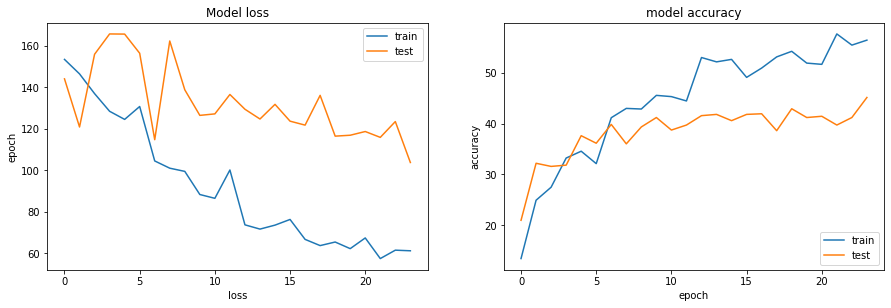

In [44]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(train_losses)
plt.plot(test_losses)
plt.title('Model loss')
plt.xlabel("loss")
plt.ylabel("epoch")
plt.legend(['train', 'test'], loc='upper right')

plt.subplot(2,2,2)
plt.plot(train_accuracies)
plt.plot(test_accuracies)
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="lower right")

In [45]:
from itertools import chain
from sklearn.metrics import confusion_matrix, classification_report

predictions_l = [test_predictions[i].tolist() for i in range(len(test_predictions))]
labels_l = [test_labels[i].tolist() for i in range(len(test_labels))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))

# Fix to make it run in lab
predictions_l = np.ravel(predictions_l)
labels_l = np.ravel(labels_l)

In [46]:
confusion_matrix(labels_l, predictions_l)

print("Classification report for CNN :\n%s\n"
      % (classification_report(labels_l, predictions_l)))

Classification report for CNN :
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1056
           1       0.57      0.46      0.51      1056
           2       0.30      0.10      0.15       768
           3       0.33      0.33      0.33      1032
           4       0.26      0.49      0.34      1008
           5       0.37      0.33      0.35       960
           6       0.28      0.28      0.28       936
           7       0.37      0.24      0.29      1080
           8       0.33      0.25      0.28       984
           9       0.34      0.32      0.33       792
          10       0.72      0.77      0.74       912
          11       0.43      0.70      0.53       960
          12       0.50      0.42      0.46      1008
          13       0.24      0.15      0.19       984
          14       0.38      0.41      0.40      1032
          15       0.32      0.38      0.34       864
          16       0.27      0.23      0.25      